# Data Visualization Report 2

```
Date:    13 April 2018
Theme:   Explorative visual and statistical analysis
Authors: Luca Steyn, Renier Botha
```

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set()

import sys
sys.path.append('../')
import data_utils as util

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

Load the data with BASMI and Demographics information.

Also show a small preview to get an intuition for what we are working with...

In [42]:
df = pd.read_csv('../data/combined_full.csv', index_col=0, parse_dates=[1])
df.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,gender,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Age,Age_cat
patient_id,,,,,,,,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,False,Female,46.255989,Positive,False,AS,48,5.0
40,1995-06-01,3,1,8,5,3,4.0,False,Female,46.255989,Positive,False,AS,48,5.0
40,1995-06-12,2,1,5,3,2,2.6,False,Female,46.255989,Positive,False,AS,48,5.0
40,1995-11-02,1,1,3,4,2,2.2,False,Female,46.255989,Positive,False,AS,48,5.0
40,1996-05-02,2,1,4,3,2,2.4,False,Female,46.255989,Positive,False,AS,49,5.0


## Split BASMI data into different cohorts:

* Treatment: Data of patients who while and after they underwent **any** treatment
* No Treatment: Data of patients who **have not** received any treatment

To be clear, consider the following example: Patient 40 entered the study and took no biologics and also did not undergo rehab for the first 12 years. However, after 12 years the patient started using a biologic drug. This means that the first 12 years of measurements of patient 40 will be added to the "no treatment" cohort, and the latter will be added to the "treatment" cohort. 

_For this report, we merely load the data from disk_

In [43]:
treatment_df = pd.read_csv('../data/treatment_cohort.csv', index_col=0, parse_dates=[1])
no_treatment_df = pd.read_csv('../data/no_treatment_cohort.csv', index_col=0, parse_dates=[1])

print('Full dataset shape: {}'.format(df.shape))
print('No-Treatment Dataset shape: {}'.format(no_treatment_df.shape))
print('Treatment Dataset shape: {}'.format(treatment_df.shape))

Full dataset shape: (14436, 15)
No-Treatment Dataset shape: (11228, 15)
Treatment Dataset shape: (3208, 15)


## Show BS Score By Age

**Goal**: The main objective is to see if there exists any _trend_ between BS score and Age.

We will approach this by only considering the "No Treatment" cohort, and plotting the BS score by Age for all patients. 
The _mean_ BS score is taken for every year, to get one score per year for each patient.


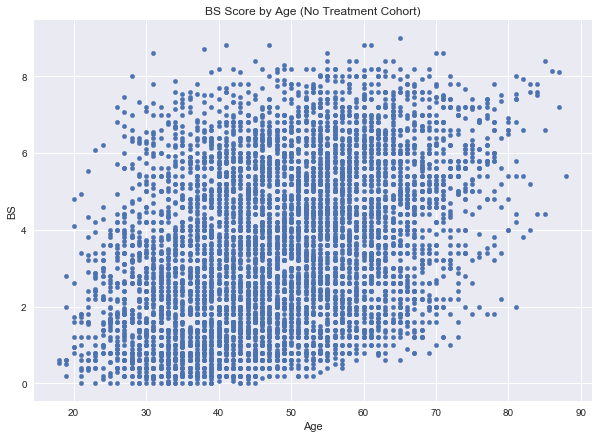

In [59]:
agg_dict = {'BS': 'mean', 'Age': min}
agg = no_treatment_df.groupby(['patient_id','Age']).agg(agg_dict)
agg.reset_index(level=1, drop=True)
agg.plot(x='Age', y='BS', kind='scatter', figsize=(10,7),
         title='BS Score by Age (No Treatment Cohort)')

There seems to be a positive trend, but with _a lot_ of variation. However, this figure contains subsequent measurements from every patient...

#### Show BS by Age for first year in study

Now take only the BS score of the first year in the study for each patient in the "No Treatment" cohort

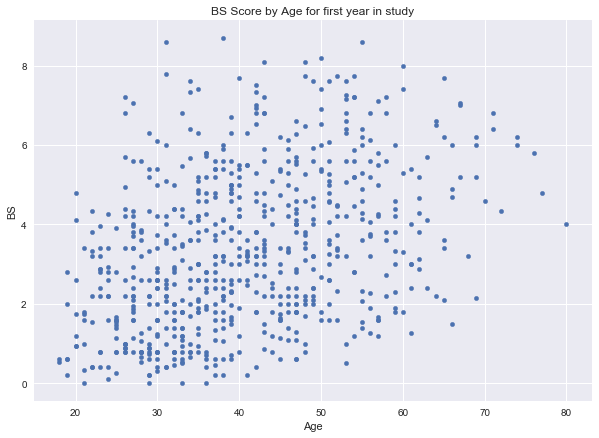

In [45]:
# Get only the first entry for each patient --> Age at entry
agg_at_entry = agg.groupby('patient_id').apply(lambda x: x.iloc[0])
agg_at_entry.plot(x='Age',y='BS', kind='scatter', figsize=(10,7),
                  title='BS Score by Age for first year in study')

### Discussion

There still seems to be positive trend, but with lots of variance. 

The goal with this step was to compare our patient BS scores with the _reference intervals_ of patients in a study that Raj sent out (link TBC). However, we were unsure how to actually compare this data and would love some feedback about how we can improve this. 

## Explore Waiting Times

**Goal**: Calculate and visualize the time patients spent between measurements. 





A preview of the data sorted by Date_diff: (Note the value of Date_diff)



,Date,Date_diff,BS_diff
patient_id,,,
7766,1996-09-12,1.0,0.0
3936,1989-02-18,1.0,0.0
3936,1989-01-31,1.0,0.0
1716,1987-11-13,1.0,-0.6
3824,1997-02-27,1.0,0.0


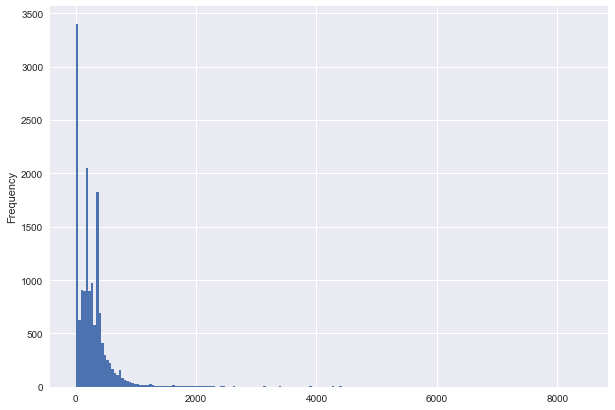

In [46]:
def get_diff(df_):
    df = df_.copy()
    df['Date_diff'] = df['Date'].diff().dt.days
    df['BS_diff'] = df['BS'].diff()
    return df.iloc[1:] # return from 1-> to drop first nan

diffs = basmi_df.groupby('patient_id').apply(get_diff)[['Date','Date_diff','BS_diff']]
diffs.reset_index(level=0, drop=True, inplace=True)

# Plot the diffs
diffs['Date_diff'].plot(kind='hist', bins=200, figsize=(10,7))
print('\n\nA preview of the data sorted by Date_diff: (Note the value of Date_diff)\n')
diffs.sort_values(by='Date_diff').head()

Interesting, an _overwhelming_ number of patients had measurements 1 day apart, which was unexpected. @Raj any comment on that?

Lets see how the graph looks if we plot for all values greater than 1 and less than 1000:

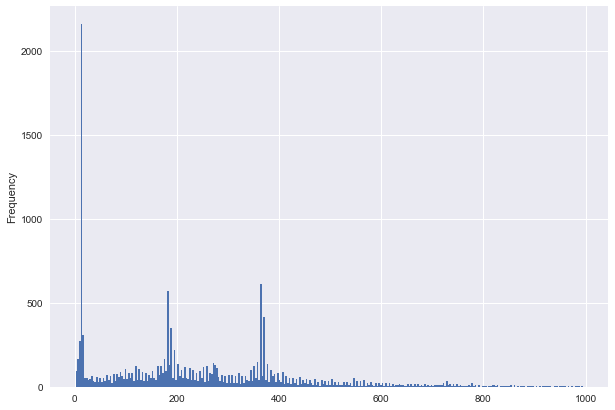

In [47]:
filtered = diffs[(diffs['Date_diff'] > 1) & (diffs['Date_diff'] < 1000)]
filtered['Date_diff'].plot(kind='hist',bins=300, figsize=(10,7))

Some interesting peaks there...lets take a look at the actual frequencies of the top 10 intervals


In [58]:
print('Top 10 occuring waiting times:')
filtered['Date_diff'].value_counts().head(10)

Top 10 occuring waiting times:


13.0     1380
12.0      569
364.0     401
182.0     322
371.0     314
189.0     197
14.0      182
18.0      177
11.0      162
183.0     130
Name: Date_diff, dtype: int64

#### Waiting Time Analysis:

So there are 1380 patients who had measurements taken 13 days apart and 570 who were measured 12 days apart.

Knowing that rehab patients are measured 14 days apart, is it possible that these patients exited the rehab earlier and were measured  11/12/13 days apart instead of 14?

Another interesting thing: The 3rd highest frequency period is 364 days - exactly one year apart, the and the 4th is 182, which is half a year apart. 

@Raj, were you expecting these insights?

# t_test On Rehab patient data

Next we do a t-test on data from patients who underwent rehab...

**Question** Is there a _significant_ difference in BS scores before and after rehab sessions?

To answer this question, we will run a "t-test" on the data from before and after patients underwent rehab.

* We will identify the rehab sessions by measurements spaced exactly 14 days apart. 
* Then we will run t-tests with different assumptions, and testing these assumptions as we progress.

The end goal is run a non-parametric test, but we will get there by first running simpler tests, thus leading up to the NP test and ensuring that the results make sense. 

**NOTE** For future work we could include measurements 11/12/13 days apart...

In [49]:
# Load the rehab data
rehab_df = pd.read_csv('../data/rehab_data.csv', index_col=0)

# Split the data into the measurements before and after rehab
before = rehab_df.iloc[::2]['BS']
after = rehab_df.iloc[1::2]['BS']
before = before[:-1]

### Simple 2-sided t-test

Notice that the test statistic is positive (indicating before - after). Python always performs a two-sided test for symmetrical tests such as the t-test. Therefore, the p-value must be dividd by two to get the one-sided p-value.

t = 4.434264190752112
p = 6.448029677903826e-06


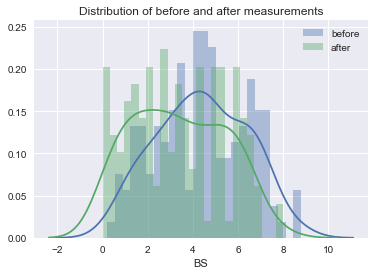

In [50]:
from scipy import stats

t, p = stats.ttest_ind(before, after)

print('t = {}'.format(t))
print('p = {}'.format(p/2))

fig = plt.figure()
sns.distplot(before, bins=25, label='before')
sns.distplot(after, bins=25, label='after')
plt.title('Distribution of before and after measurements')
plt.legend()
plt.show()

### Check the assumptions of the t-test. 

The assumptions are:
    - Both samples are normally distributed
    - Samples are independent

### Visual check for normality: Q-Q plot

We expect a straight line through the origin if the data is normally distributed.

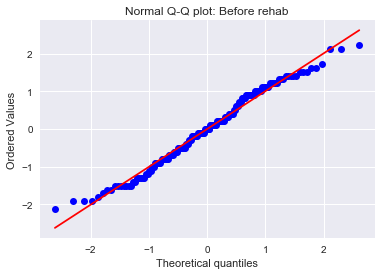

In [51]:
Z_before = (before - np.mean(before))/np.std(before)
stats.probplot(Z_before, dist='norm', plot=plt)
plt.title("Normal Q-Q plot: Before rehab")
plt.show()

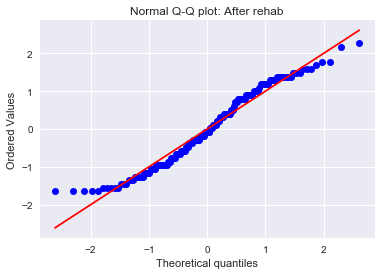

In [52]:
Z_after = (after - np.mean(after))/np.std(after)
stats.probplot(Z_after, dist='norm', plot=plt)
plt.title("Normal Q-Q plot: After rehab")
plt.show()

Notice that the Q-Q plot before the rehab is slightly more normally distributed than after rehab. It seems that the assumption that the data is normally distributed is quite strict - especially for the BS scores of patients after rehab. A similar result is seen from the histograms of the two groups. Next, we perform a formal test for normality (goodness-of-fit test) to see if each group is normally distributed. A well-known test is the Lilliefors test (Kolmogorov Smirnov test). Basically, if $X$ is the random variable with distribution $F$, we test the null hypothesis: $H_{0}: F \tilde{} N(\mu ; \Sigma) $

#### Test for normality for before

In [53]:
D_before,p_before = stats.kstest(before, 'norm')
print('BEFORE:\n')
print('The test statistic is {}'.format(D_before))
print('The p-value is {}'.format(p_before))

D_after,p_after = stats.kstest(after, 'norm')
print('AFTER:\n')
print('The test statistic is {}'.format(D_after))
print('The p-value is {}'.format(p_after))

BEFORE:

The test statistic is 0.867295288818177
The p-value is 0.0
AFTER:

The test statistic is 0.7309316524545406
The p-value is 0.0


It is seen that both tests result in a p-value of zero. Hence, there is sufficient evidence to conclude that the data is not normally distributed. The dependence in the data is now investigated next

### Checking the dependence in the data

In order to see if the data is dependent we consider the coefficient of correlation between the two groups. 

The coefficient of correlation is 0.9426747605494512
The p-value for the test for zero correlation is 2.4450261282112308e-74


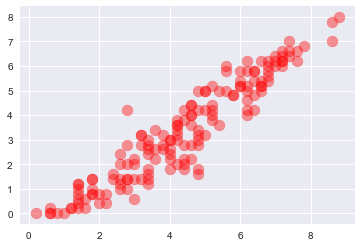

In [54]:
rho, p_rho = stats.pearsonr(before, after)
print('The coefficient of correlation is {}'.format(rho))
print('The p-value for the test for zero correlation is {}'.format(p_rho))
plt.scatter(before, after, alpha =0.4, s=121, color = 'red')

It is seen that the pearson correlation is 0.942 which is extremely high. Furthermore, the test $ H_{0}: \rho = 0 $ vs $H_{a}: \rho \neq 0 $ has a p-value of zero. Hence, there is nearly certainty that the scores before and after rehab are correlated. This is wat is expected given that the scores before and after refer to the same person.

### Paired t-test: Taking into account dependence

In [55]:
t_de, p_de = stats.ttest_rel(before, after)
print('The test statistics is {}'.format(t_de))
print('The p-value is {}'.format(p_de/2))

The test statistics is 18.424353066003054
The p-value is 5.625036977722412e-41


It is seen that even when the dependence is taken into account the p-value is extremely small. This again indicates that the difference between the BS scores before and after rehab differ significantly. 

### Non-parametric test: Taking non-normality into account
We now perform a non-parametric test to compare the means from the before and after rehab group. This test considers the order statistics of the data. The test is known as the Mann Whitney U test or Wilcoxon rank test. Notice we use the continuity correction. 

In [56]:
T_mwu, p_mwu = stats.mannwhitneyu(before, after, use_continuity=True, alternative='greater')
print('The test statistics is {}'.format(T_mwu))
print('The p-value is {}'.format(p_mwu))

The test statistics is 15104.5
The p-value is 1.6213967963023146e-05


It is again observed that the p-value is extremely small. Hence, all tests indicate that the rehab results in a reduced BS score. Therefore, rehab is an effective treatment for the patients.

## Visualize Average BS Score for Treatment and No Treatment Cohorts

In the previous report, we plotted the averge BS score over a normalized timeline. 
Now, we will show a similar plot, but split treatment cohorts.

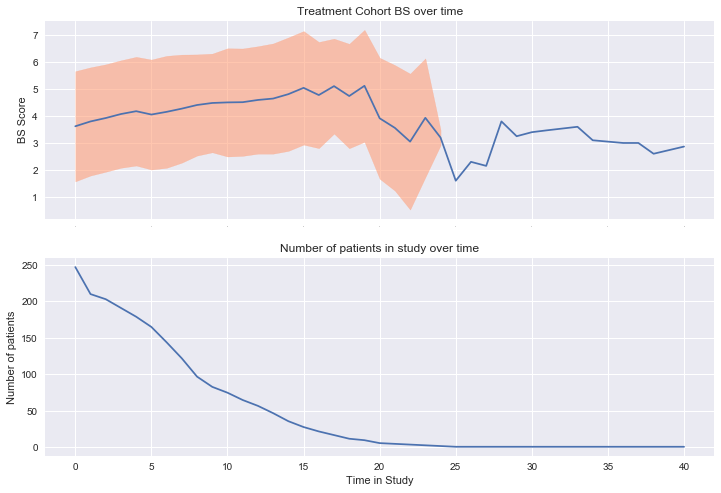

In [74]:
treatment_normed = pd.read_csv('../data/treatment_cohort_normed.csv', index_col=0)
no_treatment_normed = pd.read_csv('../data/no_treatment_cohort_normed.csv', index_col=0)

t_agg = treatment_normed.groupby('norm_years').agg({'BS': ['mean','std'] , 'norm_years': len})

title = 'Treatment Cohort BS over time'
util.plot_bs_over_time(t_agg['BS','mean'], t_agg['BS','std'], t_agg['norm_years','len'],title)

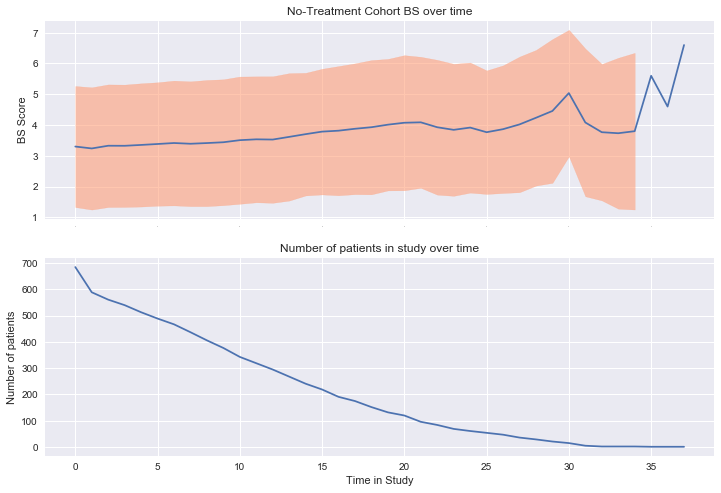

In [75]:
nt_agg = no_treatment_normed.groupby('norm_years').agg({'BS': ['mean','std'] , 'norm_years': len})

title = 'No-Treatment Cohort BS over time'
util.plot_bs_over_time(nt_agg['BS','mean'], nt_agg['BS','std'], nt_agg['norm_years','len'],title)

Although very crude, we can see that overall, patients in the No-Treatment (NT) cohort experience a slow increase in BS score. For the Treatment (T) cohort however, we can firstly see that at around 22 years in the study there is only 1 patient left in the study. Before that though, we see a slightly sharper increase. The data after 20 years in the study should not be trusted though as the number of patients have decreased to less than 50. 